In [1]:
import numpy as np
import numpy.linalg as la
from scipy.misc import logsumexp
import scipy.special
def minimum_volume_ellipsoid(points, tol=0.001):
        """
        Finds the ellipse equation in "center form":
        ``(x-c).T * A * (x-c) = 1``.
        """
        N, d = points.shape
        Q = np.column_stack((points, np.ones(N))).T
        err = tol + 1
        u = np.ones(N) / N
        while err > tol:
            # assert(u.sum() == 1) # invariant
            X = np.dot(np.dot(Q, np.diag(u)), Q.T)
            M = np.diag(np.dot(np.dot(Q.T, la.inv(X)), Q))
            jdx = np.argmax(M)
            step_size = (M[jdx] - d - 1) / ((d + 1) * (M[jdx] - 1))
            new_u = (1 - step_size) * u
            new_u[jdx] += step_size
            err = la.norm(new_u - u)
            u = new_u
        c = np.dot(u, points)
        A = la.inv(
            + np.dot(np.dot(points.T, np.diag(u)), points)
            - np.multiply.outer(c, c)
        ) / d
        return A, c

def plot_ellipse(A, c, u):
    """
    Plots a ellipse equation in "center form":
    ``(x-c).T * A * (x-c) = 1``.
    """
    A = np.linalg.inv(A)
    evs, evecs = np.linalg.eig(A)
    evs = np.sqrt(evs)
    a = evs[0]
    b = evs[1]
    x0 = c[0]
    y0 = c[1]
    alpha = np.arctan(evecs[:, 0][1] / evecs[:, 0][0])
    theta = np.linspace(0, 2 * np.pi, 1000)

    x = x0 + a * np.cos(theta) * np.cos(alpha) - b * np.sin(theta) * np.sin(alpha)
    y = y0 + a * np.cos(theta) * np.sin(alpha) + b * np.sin(theta) * np.cos(alpha)
    plt.plot(x, y)
    plt.scatter(u[:, 0], u[:, 1], c='k')
    plt.show()

def ellipse_volume_calculator(A):
    d = A.shape[0]
    r = np.sqrt(1 / np.linalg.eigvals(A))
    return (np.pi**(d / 2.0) / scipy.special.gamma((d / 2.0) + 1)) * np.prod(r)

def enlarge_ellipse_A(enlargement_factor, A):
    return (1 / enlargement_factor) * A

def V_S_calculator(i, N):
    return np.exp(-i / N)

# algorithm 1 various steps
def step_1(u):
    A, c = minimum_volume_ellipsoid(u)
    V_E = ellipse_volume_calculator(A)
    return A, c, V_E

def comparison_enlargement(V_S, V_E, A):
    if V_E > V_S:
        return A
    else:
        enlargement_factor = V_S / V_E
        return enlarge_ellipse_A(enlargement_factor, A)

def step_2(i, N, V_E, A):
    V_S = V_S_calculator(i, N)
    return comparison_enlargement(V_S, V_E, A), V_S

from scipy.cluster.vq import vq, kmeans
def step_3(u):
    centers, assignment = scipy.cluster.vq.kmeans2(u, 2)
    return centers, assignment
def ellipse_find_volume_calculator(a_index, u, assigments):
    points = u[np.where(assignment == a_index)]
    A, c = minimum_volume_ellipsoid(points)
    return A, c, ellipse_volume_calculator(A)
def ellipse_find_volume_calculator_fast(a_index, u, assignments, tol=0):
    points = u[np.where(assignments == a_index)]
    A, c = minimum_volume_ellipsoid_fast(points, tol)
    return A, c, ellipse_volume_calculator(A)
def step_4(assignments, u):
    A_l = [None] * 2
    c_l = [None] * 2
    V_E_l = [None] * 2
    for i in range(0, 2):
        A, c, V_E = ellipse_find_volume_calculator_fast(i, u, assignments)
        A_l[i] = A
        c_l[i] = c
        V_E_l[i] = V_E
    return A_l, c_l, V_E_l
def V_S_k_calculator(n_k, N, V_S):
    return n_k * V_S / N
def step_5(assignments, V_E_l, A_l, V_S):
    A_new_l = [None] * 2
    V_S_k_l = [None] * 2
    V_E_k_l = [None] * 2
    N = len(assignments)
    for i in range(0, 2):
        n = np.sum(assignments == i)
        V_S_k_l[i] = V_S_k_calculator(n, N, V_S)
        A_new_l[i] = comparison_enlargement(V_S_k_l[i], V_E_l[i], A_l[i])
        V_E_k_l[i] = ellipse_volume_calculator(A_new_l[i])
    return A_new_l, V_S_k_l, V_E_k_l
def mahalanobis_distance(point, mean, A):
    return np.matmul(np.matmul(point - mean, A), point - mean)
# Based on eqn. (16) in the paper but corrected for subtracting the means
# also added a tolerance that can be used to improve performance
def minimum_volume_ellipsoid_fast(points, tol=0.0):
    cov = np.cov(np.transpose(points))
    cov_inv = np.linalg.inv(cov)
    c = np.mean(points, axis=0)
    dist = np.zeros(len(points))
    for i in range(len(points)):
        dist[i] = mahalanobis_distance(points[i], c, cov_inv)
    enlargement_factor = np.max(dist)
    A = (1 - tol) * (1.0 / enlargement_factor) * cov_inv
    return A, c

def step_6(points, c_k_l, A_k_l, V_E_l, V_S_k_l):
    n = len(points)
    assignments_new = np.zeros(n)
    for i in range(0, n):
        h_k_max = float('inf')
        for j in range(0, 2):
            h_k = h_k_calculator(points[i], c_k_l[j],
                                 A_k_l[j], V_E_l[j], V_S_k_l[j])
            if h_k < h_k_max:
                assignments_new[i] = j
                h_k_max = h_k
    return assignments_new
def h_k_calculator(point, mean_k, A_k, V_E_k, V_S_k):
    d = mahalanobis_distance(point, mean_k, A_k)
    return V_E_k * d / V_S_k
def plot_ellipse_basic(A, c):
    """
    Plots a ellipse equation in "center form":
    ``(x-c).T * A * (x-c) = 1``.
    """
    A = np.linalg.inv(A)
    evs, evecs = np.linalg.eig(A)
    evs = np.sqrt(evs)
    a = evs[0]
    b = evs[1]
    x0 = c[0]
    y0 = c[1]
    alpha = np.arctan(evecs[:, 0][1] / evecs[:, 0][0])
    theta = np.linspace(0, 2 * np.pi, 1000)

    x = x0 + a * np.cos(theta) * np.cos(alpha) - b * np.sin(theta) * np.sin(alpha)
    y = y0 + a * np.cos(theta) * np.sin(alpha) + b * np.sin(theta) * np.cos(alpha)
    plt.plot(x, y)
def plot_many_ellipse(A_l, c_l, u):
    for i in range(0, len(A_l)):
        plot_ellipse_basic(A_l[i], c_l[i])
    plt.scatter(u[:, 0], u[:, 1], c='k')
    plt.show()

Generate 2d points uniformly (in multinest the points must be uniformly distributed in parameter space)

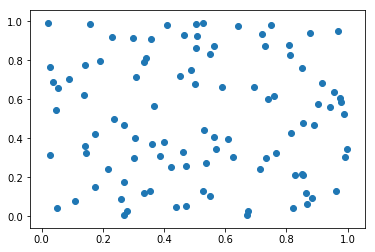

In [2]:
import matplotlib.pyplot as plt
N = 100
u = np.random.uniform(0, 1, size=(N, 2))
plt.scatter(u[:, 0], u[:, 1])
plt.show()

Calculate minimum volume ellipsoid and plot it

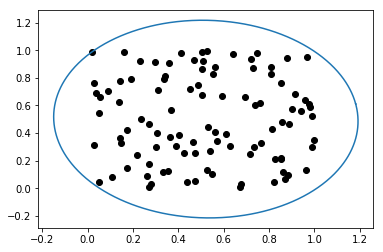

In [3]:
A, c = minimum_volume_ellipsoid_fast(u)
plot_ellipse(A, c, u)

Calculate V(S) - the volume of the space on which the points are distributed which is a function of the iteration $i$

$$V(S) = exp(-i / N),$$

where $N$ is the number of points.

In [4]:
V_S_calculator(1, N)

0.99004983374916811

Calculate volume of ellipse from its center form which is given by (https://math.stackexchange.com/questions/606184/volume-of-n-dimensional-ellipsoid),

$$V(E) = \frac{\pi^{d/2}}{\Gamma((d/2)+1)} \prod_{i=1}^{d} r_{i}$$,

where $r_i = 1 / \sqrt{\lambda_i}$ are the lengths of the semi axes and $\lambda_i$ are the eigenvalues of the matrix $A$; $d$ is the number of dimensions.

In [5]:
ellipse_volume_calculator(enlarge_ellipse_A(1.1, A)) / ellipse_volume_calculator(A)

1.1000000000000001

In [384]:
def f_s_minimisation_steps_1_to_3(i, u):
    A, c, V_E = step_1(u)
    N = len(u)
    A, V_S = step_2(i, N, V_E, A)
    V_E = ellipse_volume_calculator(A)
    centers, assignments = step_3(u)
    return assignments, A, N, V_E, V_S, c
def f_s_minimisation_lines_4_to_13(assignments, u, V_S, max_recursion):
    A_k_l, c_k_l, V_E_l = step_4(assignments, u)
    A_new_l, V_S_k_l, V_E_k_l = step_5(assignments, V_E_l, A_k_l, V_S)
    assignments_new = step_6(u, c_k_l, A_k_l, V_E_k_l, V_S_k_l)
    assignments_new = assignments_new.astype(int)
    # stops algorithmic oscillation (not in original algorithm)
    if max_recursion > 20:
        return assignments_new, A_new_l, V_S_k_l, c_k_l, V_E_k_l
    if np.array_equal(assignments, assignments_new):
        return assignments_new, A_new_l, V_S_k_l, c_k_l, V_E_k_l
    else:
        return f_s_minimisation_lines_4_to_13(assignments_new, u, V_S, max_recursion + 1)
def f_s_minimisation_lines_2_onwards(u, V_E, V_S, A, c):
    A = comparison_enlargement(V_S, V_E, A)
    V_E = ellipse_volume_calculator(A)
    centers, assignments = step_3(u)
    assignments_new, A_new_l, V_S_k_l, c_k_l, V_E_k_l = f_s_minimisation_lines_4_to_13(assignments, u, V_S, 1)
    # lines 14 onwards
    V_E_k_tot = np.sum(V_E_k_l)
    if V_E_k_tot < V_E:
        A_k_l = [None] * 2
        c_k_l1 = [None] * 2
        for i in range(0, 2):
            u_new = u[np.where(assignments_new == i)]
            A_k_l[i], c_k_l1[i] = f_s_minimisation_lines_2_onwards(u_new, V_E_k_l[i], V_S_k_l[i], A_new_l[i], c_k_l[i])
        return A_k_l, c_k_l1
    else:
        return A, c
def f_s_minimisation(iteration, u):
    assignments, A, N, V_E, V_S, c = f_s_minimisation_steps_1_to_3(iteration, u)
    assignments_new, A_new_l, V_S_k_l, c_k_l, V_E_k_l = f_s_minimisation_lines_4_to_13(assignments, u, V_S, 1)
    # lines 14 onwards
    V_E_k_tot = np.sum(V_E_k_l)
    if V_E_k_tot < V_E:
        A_k_l = [None] * 2
        c_k_l1 = [None] * 2
        for i in range(0, 2):
            u_new = u[np.where(assignments_new == i)]
            A_k_l[i], c_k_l1[i] = f_s_minimisation_lines_2_onwards(u_new, V_E_k_l[i], V_S_k_l[i], A_new_l[i], c_k_l[i])
        return A_k_l, c_k_l1
    else:
        return [A], [c]

In [385]:
def draw_from_ellipsoid(covmat, cent, npts):
        """
        Draw `npts` random uniform points from within an ellipsoid with a
        covariance matrix covmat and a centroid cent, as per:
        http://www.astro.gla.ac.uk/~matthew/blog/?p=368
        """
        try:
            ndims = covmat.shape[0]
        except IndexError:  # pragma: no cover
            ndims = 1

        # calculate eigen_values (e) and eigen_vectors (v)
        eigen_values, eigen_vectors = la.eig(covmat)
        idx = (-eigen_values).argsort()[::-1][:ndims]
        e = eigen_values[idx]
        v = eigen_vectors[:, idx]
        e = np.diag(e)

        # generate radii of hyperspheres
        rs = np.random.uniform(0, 1, npts)

        # generate points
        pt = np.random.normal(0, 1, [npts, ndims])

        # get scalings for each point onto the surface of a unit hypersphere
        fac = np.sum(pt**2, axis=1)

        # calculate scaling for each point to be within the unit hypersphere
        # with radii rs
        fac = (rs**(1 / ndims)) / np.sqrt(fac)
        pnts = np.zeros((npts, ndims))

        # scale points to the ellipsoid using the eigen_values and rotate with
        # the eigen_vectors and add centroid
        d = np.sqrt(np.diag(e))
        d.shape = (ndims, 1)

        for i in range(0, npts):
            # scale points to a uniform distribution within unit hypersphere
            pnts[i, :] = fac[i] * pt[i, :]
            pnts[i, :] = np.dot(
                np.multiply(pnts[i, :], np.transpose(d)),
                np.transpose(v)
            ) + cent

        return pnts

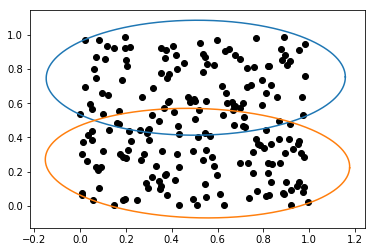

In [392]:
u = np.random.uniform(0, 1, size=(200, 2))
A, c = f_s_minimisation(1, u)
plot_many_ellipse(A, c, u)

Now demonstrate algorithm working in 2d as in Fig. 3 of the multinest paper

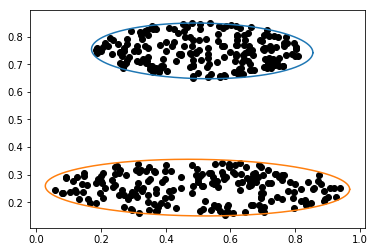

In [393]:
n = 200
p1 = draw_from_ellipsoid(np.array([[0.2, 0.], [0., 0.01]]), [0.5, 0.25], n)
p2 = draw_from_ellipsoid(np.array([[0.1, 0.], [0., 0.01]]), [0.5, 0.75], n)
u = np.concatenate((p1, p2))
A, c = f_s_minimisation(1000, u)
plot_many_ellipse(A, c, u)

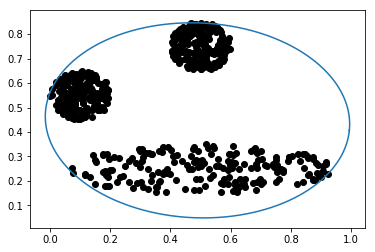

In [366]:
iteration1 = 1000
A, c, V_E = step_1(u)
plot_ellipse(A, c, u)

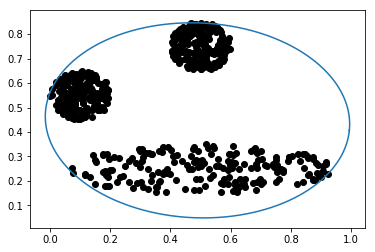

In [368]:
N = len(u)
A, V_S = step_2(iteration1, N, V_E, A)
plot_ellipse(A, c, u)

In [369]:
centers, assignments = step_3(u)
centers

array([[ 0.56093329,  0.55499481],
       [ 0.14509973,  0.47378988]])

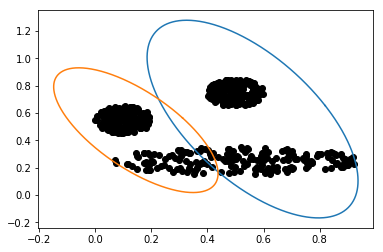

In [370]:
A_k_l, c_k_l, V_E_l = step_4(assignments, u)
plot_many_ellipse(A_k_l, c_k_l, u)

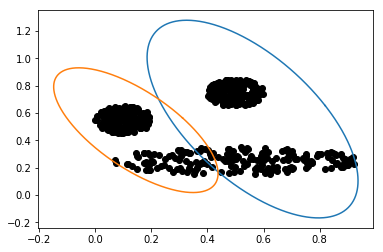

In [371]:
A_new_l, V_S_k_l, V_E_k_l = step_5(assignments, V_E_l, A_k_l, V_S)
plot_many_ellipse(A_new_l, c_k_l, u)

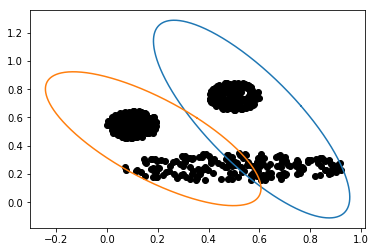

In [372]:
assignments, A, N, V_E, V_S, c = f_s_minimisation_steps_1_to_3(iteration1, u)
assignments_new, A_new_l, V_S_k_l, c_k_l, V_E_k_l = f_s_minimisation_lines_4_to_13(assignments, u, V_S, 1)
plot_many_ellipse(A_new_l, c_k_l, u)

In [248]:
V_E_k_tot = np.sum(V_E_k_l)

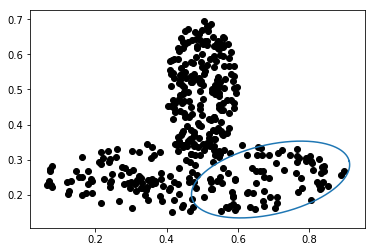

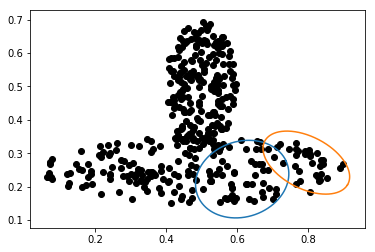

In [249]:
assignments, A, N, V_E, V_S, c = f_s_minimisation_steps_1_to_3(iteration1, u)
assignments_new, A_new_l, V_S_k_l, c_k_l, V_E_k_l = f_s_minimisation_lines_4_to_13(assignments, u, V_S, 1)
i = 0
u_new = u[np.where(assignments_new == i)]
A = comparison_enlargement(V_S_k_l[i], V_E_k_l[i], A_new_l[i])
V_E = ellipse_volume_calculator(A)
plot_ellipse(A, c_k_l[i], u)
centers, assignments = step_3(u_new)
assignments
assignments_new, A_new_l, V_S_k_l, c_k_l, V_E_k_l = f_s_minimisation_lines_4_to_13(assignments, u_new, V_S_k_l[i], 1)
plot_many_ellipse(A_new_l, c_k_l, u)

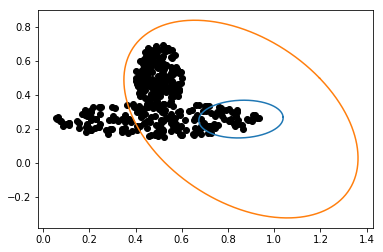

In [218]:
plot_many_ellipse([A_new_l[i],A], [c_k_l[i],c_k_l[i]], u)